In [61]:
%%writefile outlkm_algor.py
import numpy as np
import copy
from scipy.spatial import distance
from sklearn.cluster import KMeans

class OutlierKmeansAlgor():
    
    def __init__(self, num_points, dimensions, num_clusters, max_iter, seed, init_type='random',
                threshold_dis = 10., threshold_criterion = 0.01, 
                 max_no_improvement = 3, num_part_of_closest_points = 0.9,
                percent_tosample = 0.25):
        self.num_points = num_points
        self.dimensions = dimensions
        self.num_clusters = num_clusters
        self.max_iter = max_iter
        self.random_state = seed
        self.init_type = init_type
        self.threshold_dis = threshold_dis
        self.threshold_criterion = threshold_criterion
        self.max_no_improvement = max_no_improvement
        self.num_part_of_closest_points = num_part_of_closest_points
        self.percent_tosample = percent_tosample
        self._lables = []
        
        self.labels_ = None
        self.previous_centers = None
        self.k_means = None
        self.no_improvement = 0
        self.finalized = False
        
    def fit(self, points):
        all_points = copy.copy(points)
        num_sample = np.int(np.floor((len(points) * self.percent_tosample)))
        idx = np.random.randint(len(points), size = num_sample)
        points = all_points[idx]
        if self.k_means is None:
            self.init_bige(points)
            self.k_means = KMeans(init=self.init_type, n_clusters = self.num_clusters,
                                 n_init=50,
                                 max_iter = self.max_iter, random_state = self.random_state)
            
        
        self.k_means.fit(points - self.big_E)
        self.sovl_ol_problem(points)
        centers = self.k_means.cluster_centers_
        if self.previous_centers is not None:
            delta =  centers - self.previous_centers
            #print("delta :", delta)
            if np.sqrt(np.sum( (np.array(centers) - np.array(self.previous_centers)) ** 2 ))  < self.threshold_criterion:
                #print("cluster center is not improving")
                self.no_improvement += 1
            else:
                self.no_improvement = 0
        self.previous_centers = centers
        self._lables = self.k_means.predict(all_points)
        
        #check if we stop earlier, invoker will have to decide fit or not
        if self.no_improvement >= self.max_no_improvement:
            self.finalized = True
        
        
    def init_bige(self, points):
        num_sample = len(points)
        self.big_E = np.zeros((num_sample, self.dimensions))        
        mu = np.mean(points, axis=0)
        point_dis = np.apply_along_axis(lambda i: distance.euclidean(i, mu), 1, points)
        copy_point_dis = copy.copy(point_dis)
        copy_point_dis.sort()
        # retrieve 90% closest elements 
        idx = np.int(np.floor(len(points) * self.num_part_of_closest_points))
        init_out_of_clus_distance = copy_point_dis[idx]
        for i in range(len(points)):
            if point_dis[i] > init_out_of_clus_distance:
                self.big_E[i] = points[i]
            
        return
    
    def sovl_ol_problem(self, points):
        centers = self.k_means.cluster_centers_
        kmeans_labels = self.k_means.labels_
        for i in range(len(points)):
            x_center = centers[kmeans_labels[i]]
            temp_ei = np.array(points[i] - x_center)
            term = max(0,  1- self.threshold_dis / max(0.01, distance.euclidean(points[i], x_center)) )
            self.big_E[i] = temp_ei * term 
        return
    
    @property
    def labels(self):
        return self._lables
    
    @property
    def get_all_members(self):
        return {i: np.where(self._lables == i)[0] for i in range(self.num_clusters)}        
    
    
        
 

Overwriting outlkm_algor.py


In [20]:
num_points = 300
dimensions = 3
points = np.random.normal(0, 2.0, [num_points, dimensions])

km = OutlierKmeansAlgor(num_points, dimensions, num_clusters = 6, max_iter=5, 
                       seed = 9, init_type='random')

for _ in range(100):
    km.fit(points)
    
    if km.finalized:
        break
        
print(km.labels)
print(km.get_all_members)

[4 2 2 4 3 2 3 0 1 1 1 5 5 2 5 3 4 0 2 4 5 3 1 0 3 0 1 0 3 1 1 2 4 2 4 4 0
 1 4 1 5 5 0 3 0 0 3 4 3 3 2 4 2 5 1 1 0 4 3 2 4 1 0 0 5 1 0 1 4 1 1 2 1 5
 1 0 0 3 5 1 1 0 1 1 4 5 3 5 5 1 3 4 3 1 2 5 1 2 4 0 5 1 1 4 1 0 0 4 5 0 0
 3 3 4 4 5 5 2 3 4 1 1 3 0 0 4 1 0 3 4 0 3 4 4 4 3 5 0 5 4 2 4 0 4 1 0 0 4
 3 4 5 5 4 3 1 0 1 0 2 2 1 3 0 2 4 1 0 4 2 1 3 1 0 4 1 1 4 0 2 2 5 5 2 3 1
 0 4 2 3 2 4 4 5 0 1 4 5 4 4 1 1 0 5 5 1 3 4 1 4 0 4 4 4 5 3 5 4 2 4 4 0 1
 0 1 4 4 1 4 4 0 4 3 0 1 4 0 3 1 4 3 5 5 2 3 0 5 5 5 1 0 5 3 0 3 2 2 3 2 1
 3 4 1 2 5 5 4 4 2 5 1 1 3 5 5 3 2 4 5 5 0 1 5 4 0 5 2 4 5 5 3 4 1 1 5 4 0
 2 0 2 3]
{0: array([  7,  17,  23,  25,  27,  36,  42,  44,  45,  56,  62,  63,  66,
        75,  76,  81,  99, 105, 106, 109, 110, 123, 124, 127, 130, 137,
       142, 145, 146, 155, 157, 162, 166, 172, 177, 185, 193, 201, 209,
       220, 222, 229, 232, 235, 244, 249, 252, 279, 283, 295, 297]), 1: array([  8,   9,  10,  22,  26,  29,  30,  37,  39,  54,  55,  61,  65,
        67,  69,  70,  72,

# Dataset FEMNIST

In [3]:
import pandas as pd
import numpy as np

df = pd.read_json('metrics/femnist_ok_history.json')

temp = df['micro-accuracy']
fem_outkm_his = np.array(temp)
fem_outkm_his.sort()
print(fem_outkm_his)

df = pd.read_json('metrics/femnist_sp_history.json')

temp = df['micro-accuracy']
fem_sp_his = np.array(temp)
fem_sp_his.sort()
print(fem_sp_his)

df = pd.read_json('metrics/femnist_ok_mid10_lr05.json')

temp = df['micro-accuracy']
femnist_ok_mid10_lr05 = np.array(temp)
femnist_ok_mid10_lr05.sort()
femnist_ok_mid10_lr05

[0.06087221 0.06128316 0.12468871 0.24159877 0.43152687 0.46168402
 0.54121157 0.61967386 0.63492762 0.64293575 0.65268139 0.66778831
 0.67945163 0.68636486 0.71082072 0.71449878 0.71506985 0.71637896
 0.73303502 0.7339421  0.73626944 0.73678011 0.74881855 0.74982103
 0.76447073 0.76581781 0.76711718 0.76725416 0.77099318 0.77688073
 0.77890105 0.78176165 0.78198048 0.78472327 0.78609219 0.78852988
 0.7902714  0.79120134 0.79255316 0.7942819  0.79455972 0.79545283
 0.79716552 0.79832982 0.80747635 0.80993746 0.81210792 0.81586978
 0.81740711 0.81869865]
[0.06198991 0.06268872 0.12813825 0.23555961 0.42804214 0.4578054
 0.54116195 0.61963301 0.63715404 0.64964662 0.65686393 0.66088144
 0.67953962 0.6872046  0.72032226 0.73084883 0.73126323 0.73181908
 0.73332092 0.73528021 0.74243909 0.74257661 0.74489557 0.75036652
 0.75512423 0.75943764 0.76118021 0.76469854 0.76633774 0.76802369
 0.77007893 0.77070191 0.77325735 0.77666515 0.77721346 0.78230641
 0.78888843 0.79201471 0.79310459 0.795

In [20]:
df = pd.read_json('metrics/history6.json')
temp = df['macro']
acc_line = np.array(temp)
print(max(acc_line))

0.8856837607


In [21]:
df = pd.read_json('metrics/history6_2.json')
temp = df['macro']
acc_line2 = np.array(temp)
print(max(acc_line2))

0.8725414108


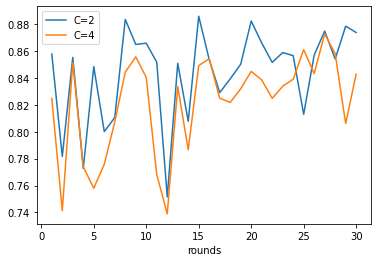

In [26]:
import matplotlib.pyplot as plt

rounds = np.arange(1, 31)
plt.plot(rounds, acc_line, label='C=2')
plt.plot(rounds, acc_line2, label='C=5')
plt.legend(loc='best')
plt.xlabel('rounds');
plt.show()

In [56]:
df = pd.read_json('metrics/history8.json')
temp = df['micro']
acc_line3 = np.array(temp)
print(acc_line3)
cluster2 = df['assignment'].iloc[2]
cluster7 = df['assignment'].iloc[7]
cluster24 = df['assignment'].iloc[24]
print(cluster2)
print(cluster7)

[0.85098944 0.81328509 0.92619949 0.85359274 0.91279944 0.87551843
 0.80777747 0.91866536 0.8382094  0.89052485 0.80973137 0.87736299
 0.87174185 0.87264734 0.87807803 0.83764142 0.84710086 0.90370103
 0.87594015 0.87853383 0.86070346 0.86471544 0.86934232 0.848791
 0.79991629 0.83627877 0.81037449 0.84408161 0.86090938 0.87252027]
{'0': ['f1834_16', 'f2167_65', 'f2087_13', 'f3258_46']}
{'0': ['f1257_26', 'f1601_01', 'f2309_54', 'f3906_44'], '2': ['f1887_23', 'f1767_34', 'f1617_41', 'f3977_39']}


In [63]:
np.median(acc_line3)

0.8628124070000001

In [58]:
df = pd.read_json('metrics/history8_2.json')
temp = df['micro']
acc_line4 = np.array(temp)
print(acc_line4)
cluster2 = df['assignment'].iloc[2]
cluster8 = df['assignment'].iloc[8]
print(cluster2)
print(cluster8)

[0.80863583 0.79898844 0.73161094 0.82447711 0.84496059 0.84151072
 0.80265693 0.87241596 0.93475482 0.83087673 0.80304005 0.86797583
 0.81495845 0.82444028 0.84046931 0.82596302 0.8367198  0.8258783
 0.83502517 0.83607419 0.85363636 0.83806611 0.81745295 0.81907384
 0.83031616 0.81442981 0.81606354 0.84276953 0.87755948 0.85015719]
{'6': ['f4092_24', 'f3944_02', 'f0930_07', 'f0423_04', 'f2027_41']}
{'0': ['f2195_64', 'f1097_20', 'f0301_33', 'f3418_34', 'f3173_48']}


In [64]:
np.median(acc_line4)

0.8305964446

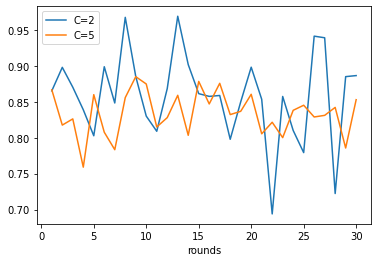

In [73]:
import matplotlib.pyplot as plt

rounds = np.arange(1, 31)
plt.plot(rounds, acc_line3, label='C=2')
plt.plot(rounds, acc_line4, label='C=5')
plt.legend(loc='best')
plt.xlabel('rounds');
plt.show()

In [71]:
df = pd.read_json('metrics/history10.json')
temp = df['micro']
acc_line3 = np.array(temp)
print(acc_line3)
print(np.median(acc_line3))

[0.86501736 0.89766977 0.87007616 0.83876739 0.80262132 0.89852285
 0.84817413 0.96712329 0.88496732 0.8299438  0.80887347 0.86816387
 0.96864821 0.90148368 0.86112023 0.8573397  0.85857616 0.79774616
 0.84972293 0.89787933 0.85331005 0.69408077 0.85722813 0.80999309
 0.77922078 0.94099379 0.93875124 0.72239108 0.88476411 0.88621795]
0.85984819695


In [76]:
df = pd.read_json('metrics/history10_2.json')
temp = df['micro']
acc_line4 = np.array(temp)
print(acc_line4)
print(np.median(acc_line4))

[0.86650454 0.81746106 0.82606441 0.75904708 0.8597289  0.80754176
 0.7832746  0.85564695 0.88471475 0.8745532  0.81482802 0.82782926
 0.85884298 0.80328198 0.87813033 0.8468387  0.87549991 0.83203736
 0.83660951 0.86025525 0.80533394 0.82138854 0.80004322 0.83797316
 0.84504592 0.82871914 0.83098676 0.84203581 0.78564586 0.85273385]
0.8343234372500001


# Dataset CELEBA

In [43]:
import pandas as pd

df = pd.read_json('metrics/celeba_sp_history.json')

temp = df['micro-accuracy']
cel_sp_his = np.array(temp)
cel_sp_his.sort()
cel_sp_his

array([ 0.57530998,  0.58101376,  0.60049121,  0.61908269,  0.62645532,
        0.6654555 ,  0.68528205,  0.69829727,  0.70402069,  0.71319841,
        0.71587348,  0.72022432,  0.7252026 ,  0.73188388,  0.74006978,
        0.74283311,  0.75952381,  0.76858974,  0.77093596,  0.77765065,
        0.78310101,  0.79771309,  0.8034827 ,  0.80887283,  0.81085586,
        0.81212281,  0.81376263,  0.81622654,  0.82046703,  0.82611903,
        0.83022774,  0.83788707,  0.84188948,  0.84222222,  0.84444444,
        0.84889204,  0.85685072,  0.86090686,  0.86390977,  0.87192699,
        0.87648084,  0.87774725,  0.87820513,  0.88373358,  0.89613045,
        0.90370665,  0.91851852,  0.92365591,  0.93191011,  0.94038792])

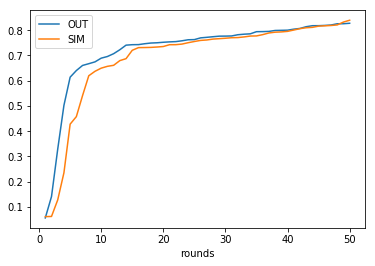

In [14]:
import matplotlib.pyplot as plt

rounds = np.arange(1, 51)
plt.plot(rounds, femnist_ok_mid10_lr05, label='OUT')
plt.plot(rounds, fem_sp_his, label='SIM')
plt.legend(loc='best')
plt.xlabel('rounds');
plt.show()

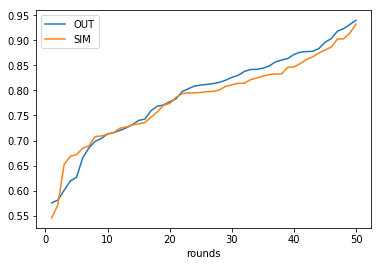

In [53]:
import matplotlib.pyplot as plt

rounds = np.arange(1, 51)
plt.plot(rounds, cel_sp_his, label='OUT')
plt.plot(rounds, cel_kmmid03_his, label='SIM')
plt.legend(loc='best')
plt.xlabel('rounds');
plt.show()

In [45]:
import pandas as pd

df = pd.read_json('metrics/history0.json')

temp = df['micro-accuracy']
cel_kmlow_his = np.array(temp)
cel_kmlow_his.sort()
cel_kmlow_his

array([ 0.55991494,  0.56873162,  0.58333333,  0.58601451,  0.60589935,
        0.61082251,  0.61458333,  0.61809374,  0.65889655,  0.65962479,
        0.66145833,  0.66145833,  0.66165414,  0.66181243,  0.6624789 ,
        0.66415701,  0.66557018,  0.6875    ,  0.69260323,  0.72202413,
        0.72894434,  0.73958333,  0.73958333,  0.74069429,  0.74282297,
        0.75714972,  0.76009011,  0.76138358,  0.77083333,  0.7797773 ,
        0.78493158,  0.79364395,  0.79499582,  0.80042809,  0.80348259,
        0.80522222,  0.80669367,  0.81281203,  0.8203125 ,  0.8255102 ,
        0.82552083,  0.82724836,  0.84375   ,  0.84375   ,  0.84375   ,
        0.84950249,  0.87316083,  0.890625  ,  0.890625  ,  0.92434211])

In [36]:
import pandas as pd

df = pd.read_json('metrics/celeba_ok_history.json')

temp = df['micro-accuracy']
cel_outkm_his = np.array(temp)
cel_outkm_his.sort()
cel_outkm_his

array([ 0.55488822,  0.63805741,  0.65865103,  0.663086  ,  0.66668929,
        0.66898436,  0.69024842,  0.70608108,  0.70702118,  0.708009  ,
        0.71453634,  0.7153804 ,  0.7177402 ,  0.71982265,  0.7255059 ,
        0.72746746,  0.74243829,  0.75153535,  0.75580952,  0.7558835 ,
        0.76464138,  0.77016063,  0.77110679,  0.77840909,  0.78200549,
        0.79192547,  0.79983974,  0.80064143,  0.8034827 ,  0.80690253,
        0.80887283,  0.81656467,  0.81703297,  0.81772152,  0.82965686,
        0.84188948,  0.85212281,  0.86247723,  0.86263318,  0.86382022,
        0.87185952,  0.87192699,  0.87521368,  0.87648084,  0.87820513,
        0.88373358,  0.88687488,  0.89074074,  0.89139785,  1.        ])

In [47]:
import pandas as pd

df = pd.read_json('metrics/history1.json')

temp = df['micro-accuracy']
cel_kmmid_his = np.array(temp)
cel_kmmid_his.sort()
cel_kmmid_his

array([ 0.52138148,  0.58194181,  0.60651461,  0.65762463,  0.66532029,
        0.66729588,  0.701814  ,  0.70615377,  0.71284271,  0.71358372,
        0.71781843,  0.71826608,  0.72137536,  0.73072384,  0.73329937,
        0.73358322,  0.74589532,  0.7546445 ,  0.75714972,  0.77050265,
        0.77253606,  0.77798343,  0.7793765 ,  0.78800006,  0.79320988,
        0.80240086,  0.80285791,  0.80441017,  0.80445344,  0.8056391 ,
        0.80807362,  0.81810385,  0.82043651,  0.82049383,  0.82833231,
        0.83223233,  0.83366853,  0.83417098,  0.83493215,  0.83794872,
        0.8387056 ,  0.8530392 ,  0.85924789,  0.88006757,  0.889847  ,
        0.89758212,  0.90614618,  0.9082308 ,  0.918379  ,  0.98148148])

In [52]:
import pandas as pd

df = pd.read_json('metrics/history2.json')

temp = df['micro-accuracy']
cel_kmmid03_his = np.array(temp)
cel_kmmid03_his.sort()
cel_kmmid03_his

array([ 0.54528531,  0.5715812 ,  0.65193034,  0.66832202,  0.67181317,
        0.68441199,  0.68929969,  0.70782796,  0.70907866,  0.71254842,
        0.71588112,  0.72469187,  0.72681704,  0.73131955,  0.73320315,
        0.73605667,  0.74648169,  0.75714972,  0.77029915,  0.7741976 ,
        0.78604497,  0.79363653,  0.7952381 ,  0.7952381 ,  0.79600694,
        0.79773553,  0.79808081,  0.80097259,  0.80827654,  0.81115108,
        0.81442538,  0.81446738,  0.82146233,  0.82492438,  0.82867133,
        0.8316534 ,  0.83290925,  0.83293076,  0.84613121,  0.84703453,
        0.8535593 ,  0.86174724,  0.86720483,  0.87472767,  0.88095238,
        0.88666667,  0.90277778,  0.90326158,  0.91460987,  0.93274076])